
### **| MBA-DSA USP-ESALQ 2022-2024**
### **| Inteligência Artificial para predição de acidentes de trânsito na rodovia BR-101**
##### **| Análise de dados de acidentes ocorridos entre 2018 e 2023**
###### | Dataset disponível em: <https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf>



### **2 - Aprendizado de Máquina (Learning Algorithm) e 3 - Avaliação dos Modelos (Valuation)**
##### Importação das bibliotecas e do dataset filtrado com dados da BR-101 entre 2018 a 2023

In [1]:
# Importação das Bibliotecas para análise dos dados:
import pandas as pd
import numpy as np

# Plotagem de Dados:
import matplotlib.pyplot as plt
import seaborn as sns

# Aprendizado de Máquina: 

import sklearn
import imblearn


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Aprendizado de Máquina Regressão Logística: 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, confusion_matrix, roc_curve, auc

# Aprendizado de Máquina Random Forest: 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, jaccard_score, classification_report
from sklearn.tree import plot_tree


#------------------------------------------------------------------------------------------- 
# Conferindo a versão das Bibliotecas que serão utilizas:
print("Scikit-learn version:", sklearn.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Imbalanced-learn version:", imblearn.__version__)



Scikit-learn version: 1.2.2
Pandas version: 2.0.3
Numpy version: 1.25.2
Imbalanced-learn version: 0.12.3


In [2]:
#Importação do dataset filtrado com dados da BR-101 entre 2018 a 2023:
df_copia = pd.read_csv('C:/Users/filipe/anaconda3/envs/tccdsa1/projetof/util/001PreProcessamento/002Filtragem_e_analise_exploratória_de_dados/df_copia.csv', sep=',', encoding='utf-8', low_memory=False)
#df_filtrado101 = pd.read_csv('C:/Users/filipe/anaconda3/envs/tccdsa1/ProjetoF2/df_filtrado101.csv', sep=',', encoding='utf-8', low_memory=False)

# Imprimir a quantidade de linhas e colunas:
print(f"Shape: O DataFrame possui {df_copia.shape[0]} linhas e {df_copia.shape[1]} colunas.\n")

# Exibindo informações gerais sobre o dataset:
#print(df_copia.info())

# Visualizando as primeiras linhas do dataset
#print(df_copia.head())



Shape: O DataFrame possui 288010 linhas e 26 colunas.



### 2.1 - Modelo de **Regressão Logística** usando **Grid Search**
##### Separação dos conjuntos de dados de Treinamento e de Teste: 

In [3]:
# Converta a coluna 'data_inversa' para datetime (se já não estiver convertida)
df_copia['data_inversa'] = pd.to_datetime(df_copia['data_inversa'])

# Extraindo o ano da data e convertendo para inteiro
df_copia['ano'] = df_copia['data_inversa'].dt.year.astype(int)

# Filtrando os dados para o período de 2018 a 2023
df_copia = df_copia[df_copia['ano'].between(2018, 2023)]

# Definindo as variáveis de entrada e a variável de saída
features = ['br', 'idade', 'dia_semana', 'horario', 'uf', 'municipio', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'sexo']
X = df_copia[features]

# Criando a variável de saída com quatro classes
conditions = [
    (df_copia['feridos_leves'] > 0),
    (df_copia['feridos_graves'] > 0),
    (df_copia['mortos'] > 0),
    (df_copia['ilesos'] > 0)
]
choices = [0, 1, 2, 3]
df_copia['class'] = np.select(conditions, choices, default=3)
y = df_copia['class']

# Transformação de dados não numéricos em dados numéricos
encoder = LabelEncoder()
for column in ['dia_semana', 'horario', 'uf', 'municipio', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'sexo']:
    X[column] = encoder.fit_transform(X[column])

## Normalização dos dados
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

## Separação dos dados de treinamento e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Separação dos dados de treinamento e teste com estratificação
train_data = df_copia[(df_copia['ano'] >= 2018) & (df_copia['ano'] <= 2021)]
test_data = df_copia[(df_copia['ano'] >= 2022) & (df_copia['ano'] <= 2023)]

X_train = train_data[features]
y_train = train_data['class']
X_test = test_data[features]
y_test = test_data['class']

# Transformação de dados não numéricos em dados numéricos
encoders = {}
for column in ['dia_semana', 'horario', 'uf', 'municipio', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'sexo']:
    encoders[column] = LabelEncoder()
    X_train[column] = encoders[column].fit_transform(X_train[column])
    # Verifica se há rótulos desconhecidos em X_test
    unknown_labels = set(X_test[column]) - set(encoders[column].classes_)
    if unknown_labels:
        encoders[column].classes_ = np.append(encoders[column].classes_, list(unknown_labels))
    X_test[column] = encoders[column].transform(X_test[column])

# Normalização dos dados
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Imprimindo o tamanho dos dados de treinamento e de teste
print(f"Tamanho dos dados de treinamento: {X_train.shape[0]}")
print(f"Tamanho dos dados de teste: {X_test.shape[0]}")

# Definindo o modelo e os parâmetros para o Grid Search
logistic_model = LogisticRegression(class_weight='balanced', multi_class='multinomial', solver='lbfgs')
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2']
}

# Aplicando Grid Search com validação cruzada
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Melhor modelo encontrado pelo Grid Search
best_model = grid_search.best_estimator_

# Previsões
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)


C:\Users\filipe\AppData\Local\Temp\ipykernel_7196\1749790890.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = encoder.fit_transform(X[column])
C:\Users\filipe\AppData\Local\Temp\ipykernel_7196\1749790890.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = encoder.fit_transform(X[column])
C:\Users\filipe\AppData\Local\Temp\ipykernel_7196\1749790890.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Tamanho dos dados de treinamento: 201607
Tamanho dos dados de teste: 86403


### 3.1 - Avaliação do Modelo de **Regressão Logística** (Evaluation):
##### Resultados do modelo usando **Regressão Logística** e **GridSearch**: Matriz de confusão,  Precisão, Acurácia, Overfitting...: 

Métricas de Regressão Logística - Treinamento:
Acurácia: 0.43706815735564736
Precisão: 0.5261916064817264
Recall: 0.43706815735564736
F1 Score: 0.46827692873996724
Índice de Jaccard: 0.3204638961219568

Métricas de Regressão Logística - Teste:
Acurácia: 0.4337002187424048
Precisão: 0.5201696693816165
Recall: 0.4337002187424048
F1 Score: 0.4635492811461862
Índice de Jaccard: 0.31595413287554064

 Comparação de Métricas:
Overfitting - Regressão Logística: 0.0033679386132425826
Matriz de Confusão - Regressão Logística:
Esses valores representam a performance do modelo em cada classe: 
Classe 0 (Feridos Leves); Classe 1 (Feridos Graves); Classe 2 (Mortos); Classe 3 (Ilesos);


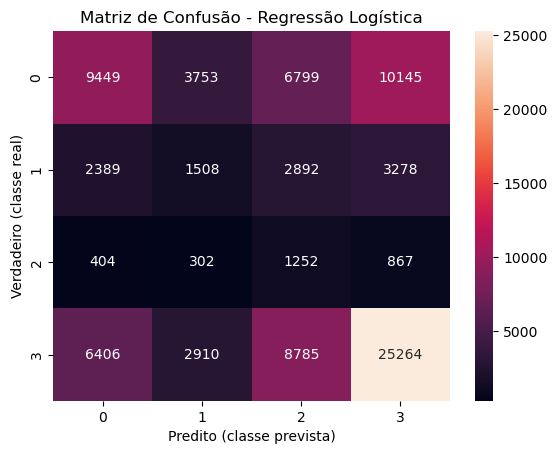

Matriz de Confusão - Regressão Logística:
[[ 9449  3753  6799 10145]
 [ 2389  1508  2892  3278]
 [  404   302  1252   867]
 [ 6406  2910  8785 25264]]


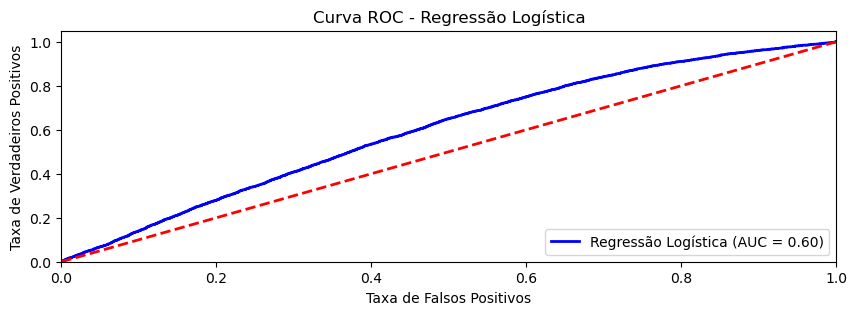

In [4]:
# Avaliação do modelo nos dados de treinamento
accuracy_train = accuracy_score(y_train, y_train_pred)
precision_train = precision_score(y_train, y_train_pred, average='weighted')
recall_train = recall_score(y_train, y_train_pred, average='weighted')
f1_train = f1_score(y_train, y_train_pred, average='weighted')
jaccard_train = jaccard_score(y_train, y_train_pred, average='weighted')

# Avaliação do modelo nos dados de teste
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred, average='weighted')
recall_test = recall_score(y_test, y_test_pred, average='weighted')
f1_test = f1_score(y_test, y_test_pred, average='weighted')
jaccard_test = jaccard_score(y_test, y_test_pred, average='weighted')

# Verificação de overfitting
overfitting = (accuracy_train - accuracy_test) 


print("Métricas de Regressão Logística - Treinamento:")
print(f"Acurácia: {accuracy_train}")
print(f"Precisão: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")
print(f"Índice de Jaccard: {jaccard_train}")

print("\nMétricas de Regressão Logística - Teste:")
print(f"Acurácia: {accuracy_test}")
print(f"Precisão: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")
print(f"Índice de Jaccard: {jaccard_test}")

# Análise de Overfitting
print("\n Comparação de Métricas:")
print(f"Overfitting - Regressão Logística: {accuracy_train - accuracy_test}")

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusão - Regressão Logística:")
print("Esses valores representam a performance do modelo em cada classe: ")
print("Classe 0 (Feridos Leves); Classe 1 (Feridos Graves); Classe 2 (Mortos); Classe 3 (Ilesos);")
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predito (classe prevista)')
plt.ylabel('Verdadeiro (classe real)')
plt.title('Matriz de Confusão - Regressão Logística')
plt.show()

# Matriz de confusão
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusão - Regressão Logística:")
print(conf_matrix)


# Curva ROC para Regressão Logística
y_prob = best_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 3))
plt.plot(fpr, tpr, color='blue', lw=2, label='Regressão Logística (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Regressão Logística')
plt.legend(loc="lower right")
plt.show()



### 2.2 - Modelo usando **Random Forest**
##### Separação dos conjuntos de dados de Treinamento e de Teste: 


In [5]:
# Converta a coluna 'data_inversa' para datetime (se já não estiver convertida)
df_copia['data_inversa'] = pd.to_datetime(df_copia['data_inversa'])

# Extraindo o ano da data e convertendo para inteiro
df_copia['ano'] = df_copia['data_inversa'].dt.year.astype(int)

# Filtrando os dados para o período de 2018 a 2023
df_copia = df_copia[df_copia['ano'].between(2018, 2023)]

# Definindo as variáveis de entrada e a variável de saída
features = ['br', 'idade', 'dia_semana', 'horario', 'uf', 'municipio', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'sexo']
X = df_copia[features]

# Criando a variável de saída com quatro classes
conditions = [
    (df_copia['feridos_leves'] > 0),
    (df_copia['feridos_graves'] > 0),
    (df_copia['mortos'] > 0),
    (df_copia['ilesos'] > 0)
]
choices = [0, 1, 2, 3]
df_copia['class'] = np.select(conditions, choices, default=3)
y = df_copia['class']

# Transformação de dados não numéricos em dados numéricos
encoder = LabelEncoder()
for column in ['dia_semana', 'horario', 'uf', 'municipio', 'fase_dia', 'sentido_via', 'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo', 'sexo']:
    X[column] = encoder.fit_transform(X[column])

## Normalização dos dados
#scaler = MinMaxScaler()
#X = scaler.fit_transform(X)

## Separação dos dados de treinamento e teste
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Separação dos dados de treinamento e teste com estratificação
train_data = df_copia[(df_copia['ano'] >= 2018) & (df_copia['ano'] <= 2021)]
test_data = df_copia[(df_copia['ano'] >= 2022) & (df_copia['ano'] <= 2023)]

X_train = train_data[features]
y_train = train_data['class']
X_test = test_data[features]
y_test = test_data['class']

# Normalizando os dados de treinamento e teste
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Imprimindo o tamanho dos dados de treinamento e de teste
print(f"Tamanho dos dados de treinamento: {X_train.shape[0]}")
print(f"Tamanho dos dados de teste: {X_test.shape[0]}")

# Treinando o modelo Random Forest
random_forest_model = RandomForestClassifier(class_weight='balanced', random_state=42)
random_forest_model.fit(X_train, y_train)

# Previsões
y_train_pred_rf = random_forest_model.predict(X_train)
y_test_pred_rf = random_forest_model.predict(X_test)




C:\Users\filipe\AppData\Local\Temp\ipykernel_7196\1852438559.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = encoder.fit_transform(X[column])
C:\Users\filipe\AppData\Local\Temp\ipykernel_7196\1852438559.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = encoder.fit_transform(X[column])
C:\Users\filipe\AppData\Local\Temp\ipykernel_7196\1852438559.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

Tamanho dos dados de treinamento: 201607
Tamanho dos dados de teste: 86403


### 3.2 - Avaliação do Modelo **Random Forest** (Evaluation)
##### Matriz de confusão,  Precisão, Acurácia, Overfitting...: 

Métricas de Random Forest - Treinamento:
Acurácia: 0.9942462315296592
Precisão: 0.994295031796189
Recall: 0.9942462315296592
F1 Score: 0.9942546112342293
Índice de Jaccard: 0.988583602810142

Métricas de Random Forest - Teste:
Acurácia: 0.826695832320637
Precisão: 0.829053328801454
Recall: 0.826695832320637
F1 Score: 0.8257813357236427
Índice de Jaccard: 0.7044919039581828

Comparação de Métricas:
Overfitting - Random Forest: 0.16755039920902215
Matriz de Confusão - Random Forest:
Esses valores representam a performance do modelo em cada classe: 
Classe 0 (Feridos Leves); Classe 1 (Feridos Graves); Classe 2 (Mortos); Classe 3 (Ilesos);


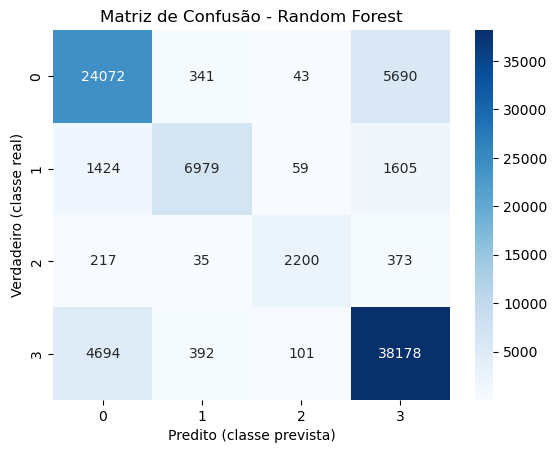

Matriz de Confusão - Random Forest:
[[24072   341    43  5690]
 [ 1424  6979    59  1605]
 [  217    35  2200   373]
 [ 4694   392   101 38178]]


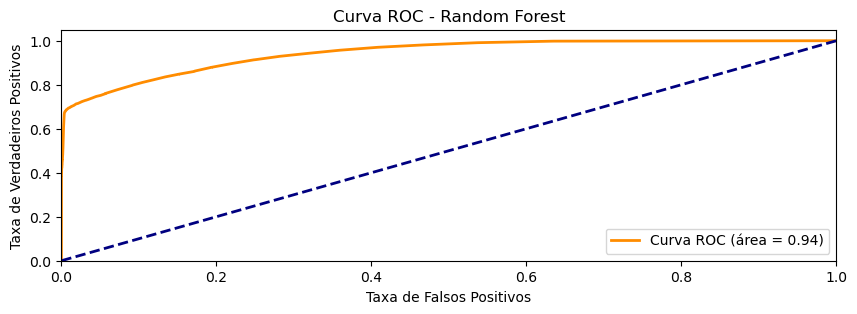

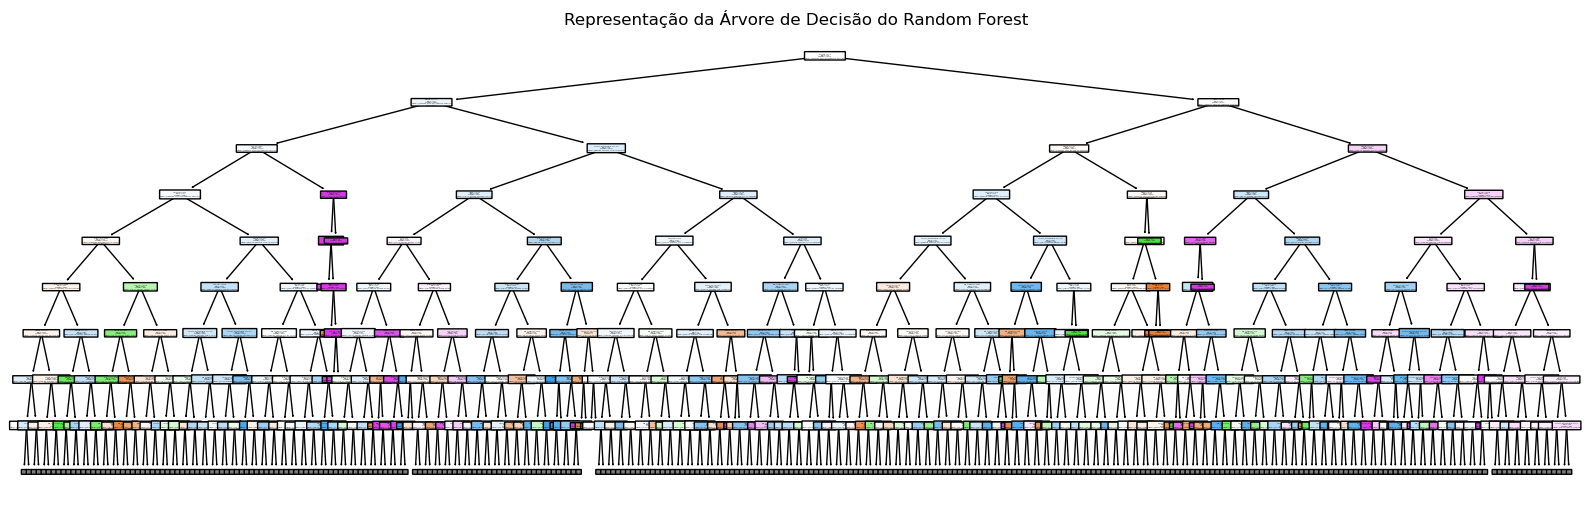

In [6]:
# Avaliação do modelo nos dados de treinamento
accuracy_train_rf = accuracy_score(y_train, y_train_pred_rf)
precision_train_rf = precision_score(y_train, y_train_pred_rf, average='weighted')
recall_train_rf = recall_score(y_train, y_train_pred_rf, average='weighted')
f1_train_rf = f1_score(y_train, y_train_pred_rf, average='weighted')
jaccard_train_rf = jaccard_score(y_train, y_train_pred_rf, average='weighted')

# Avaliação do modelo nos dados de teste
accuracy_test_rf = accuracy_score(y_test, y_test_pred_rf)
precision_test_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
recall_test_rf = recall_score(y_test, y_test_pred_rf, average='weighted')
f1_test_rf = f1_score(y_test, y_test_pred_rf, average='weighted')
jaccard_test_rf = jaccard_score(y_test, y_test_pred_rf, average='weighted')

print("Métricas de Random Forest - Treinamento:")
print(f"Acurácia: {accuracy_train_rf}")
print(f"Precisão: {precision_train_rf}")
print(f"Recall: {recall_train_rf}")
print(f"F1 Score: {f1_train_rf}")
print(f"Índice de Jaccard: {jaccard_train_rf}")

print("\nMétricas de Random Forest - Teste:")
print(f"Acurácia: {accuracy_test_rf}")
print(f"Precisão: {precision_test_rf}")
print(f"Recall: {recall_test_rf}")
print(f"F1 Score: {f1_test_rf}")
print(f"Índice de Jaccard: {jaccard_test_rf}")

# Verificação de overfitting
overfitting = (accuracy_train_rf - accuracy_test_rf) 

# Análise de Overfitting
print("\nComparação de Métricas:")
print(f"Overfitting - Random Forest: {accuracy_train_rf - accuracy_test_rf}")


# Matriz de confusão
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print("Matriz de Confusão - Random Forest:")
print("Esses valores representam a performance do modelo em cada classe: ")
print("Classe 0 (Feridos Leves); Classe 1 (Feridos Graves); Classe 2 (Mortos); Classe 3 (Ilesos);")
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predito (classe prevista)')
plt.ylabel('Verdadeiro (classe real)')
plt.title('Matriz de Confusão - Random Forest')
plt.show()

# Matriz de confusão
conf_matrix_rf = confusion_matrix(y_test, y_test_pred_rf)
print("Matriz de Confusão - Random Forest:")
print(conf_matrix_rf)

# Curva ROC para Random Forest
y_prob_rf = random_forest_model.predict_proba(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf[:, 1], pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(10,3))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'Curva ROC (área = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Random Forest')
plt.legend(loc="lower right")
plt.show()

# Plotando uma das árvores de decisão do Random Forest
plt.figure(figsize=(20,6))
plot_tree(random_forest_model.estimators_[40], feature_names=features, filled=True, rounded=True, class_names=['Feridos Leves', 'Feridos Graves', 'Mortos', 'Ilesos'], max_depth=8)
plt.title('Representação da Árvore de Decisão do Random Forest')
plt.show()


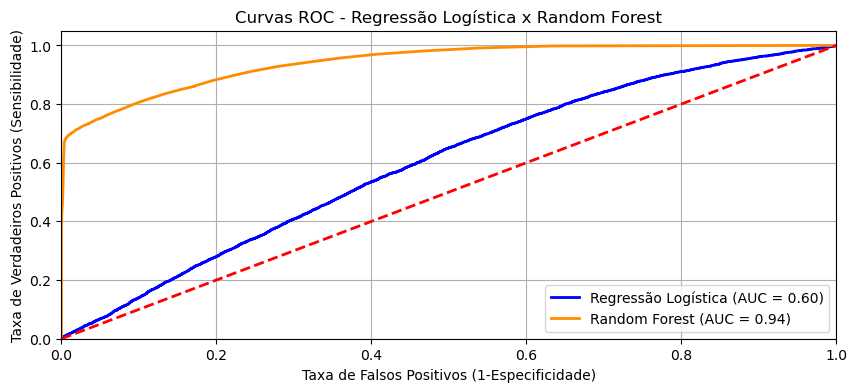

In [7]:
## Curva ROC para Regressão Logística:
y_prob = best_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

## Curva ROC para Random Forest:
y_prob_rf = random_forest_model.predict_proba(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf[:, 1], pos_label=1)
roc_auc_rf = auc(fpr_rf, tpr_rf)


# Plotando as curvas ROC para comparação
plt.figure(figsize=(10, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='Regressão Logística (AUC = %0.2f)' % roc_auc)
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (1-Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curvas ROC - Regressão Logística x Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()

